# Content of Chapter 2 - Neural Networks

In [13]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import * 
from tqdm import tqdm

### Functions from Chapter 1

In [ ]:
def moveTo(obj, device): 
    """ 
    obj: the python object to move to a device, or to move its
    ➥ contents to a device
    device: the compute device to move objects to 
    """
    if isinstance(obj, list): 
        return [moveTo(x, device) for x in obj] 
    elif isinstance(obj, tuple): 
        return tuple(moveTo(list(obj), device)) 
    elif isinstance(obj, set): 
        return set(moveTo(list(obj), device)) 
    elif isinstance(obj, dict): 
        to_ret = dict() 
        for key, value in obj.items(): 
            to_ret[moveTo(key, device)] = moveTo(value, device) 
        return to_ret 
    elif hasattr(obj, "to"): 
        return obj.to(device) 
    else: 
        return obj

<AxesSubplot:>

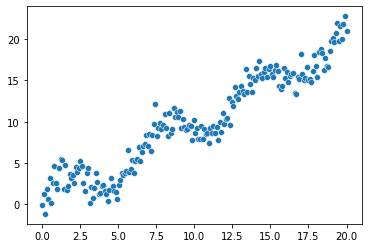

In [14]:
X = np.linspace(0, 20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [15]:
class Simple1DRegressionDataset(Dataset): 
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__() 
        self.X = X.reshape(-1,1) 
        self.y = y.reshape(-1,1) 
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self): 
        return self.X.shape[0] 
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [16]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"): 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)                    

    model.to(device)                                                             

    for epoch in tqdm(range(epochs), desc="Epoch"):                              
        model = model.train()                                                    
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):  
            inputs = moveTo(inputs, device)                                      
            labels = moveTo(labels, device)                                      

            optimizer.zero_grad()                                                


            y_hat = model(inputs)                                                

            loss = loss_func(y_hat, labels)                                      
            loss.backward()                                                      
            optimizer.step()                                                     
            running_loss += loss.item()    